In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/marathi-pre/marathi_preprocessed.csv


# Import Data, Splitting Data, Tokenization

In [2]:
df = pd.read_csv('/kaggle/input/marathi-pre/marathi_preprocessed.csv')
print(df.head())

                                               tweet  label
0  आजच्या जनता दरबारात जळगाव जिल्ह्यातील चाळीसगाव...      1
1  कुणी कविता करत असतं कुणी कविता जगत असतं कुणी क...      1
2  आम्हाला इतिहासातील औरंगजेबशी घेणे आमच्या कडे आ...      1
3  गँभीर प्रकरण महाराष्ट्राची अवस्था बिकट भाषणात ...      1
4  कब्झा कन्नड चित्रपट लवकरच मराठी मध्ये डब्ब होऊ...      1


**Install Transformer**

In [3]:
# install transformers
!pip install "transformers ==4.16.2"
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.8/61.8 kB 666.7 kB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 17.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 40.1 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.39.3
    Uninstalling transformers-4.39.3:
      Successfully uninstalled transformers-4.39.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kaggle-environments 1.14.3 requires transformers>=4.33.1, but you have transformers 4.16.2 which is incompatible.


In [4]:
# load tokens
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')

Downloading:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/615 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.68M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [5]:
df = df.rename(columns={'tweet': 'text'})

In [6]:
# print first text
df.text.values[0]

'आजच्या जनता दरबारात जळगाव जिल्ह्यातील चाळीसगावचे रहिवासी माजी सैनिक सोनू महाजन भाजपचे तत्कालीन…'

In [7]:
#print tokens of first text
print({x : tokenizer.encode(x, add_special_tokens=False) for x in df.text.values[0].split()})

{'आजच्या': [3264, 2869], 'जनता': [27620], 'दरबारात': [208231, 2535], 'जळगाव': [231172], 'जिल्ह्यातील': [168231], 'चाळीसगावचे': [15179, 24718, 1472, 58733, 3360], 'रहिवासी': [774, 15159, 105346], 'माजी': [138139], 'सैनिक': [120458], 'सोनू': [120629, 5673], 'महाजन': [10373, 14136], 'भाजपचे': [75319, 3360], 'तत्कालीन…': [159136, 27]}


In [8]:
#drop null values
df = df.dropna()

**Finding Max length of tokenized sentence**

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


max:  380
min:  3


(array([   0.,  500., 1000., 1500., 2000., 2500., 3000., 3500., 4000.]),
 [Text(0, 0.0, '0'),
  Text(0, 500.0, '500'),
  Text(0, 1000.0, '1000'),
  Text(0, 1500.0, '1500'),
  Text(0, 2000.0, '2000'),
  Text(0, 2500.0, '2500'),
  Text(0, 3000.0, '3000'),
  Text(0, 3500.0, '3500'),
  Text(0, 4000.0, '4000')])

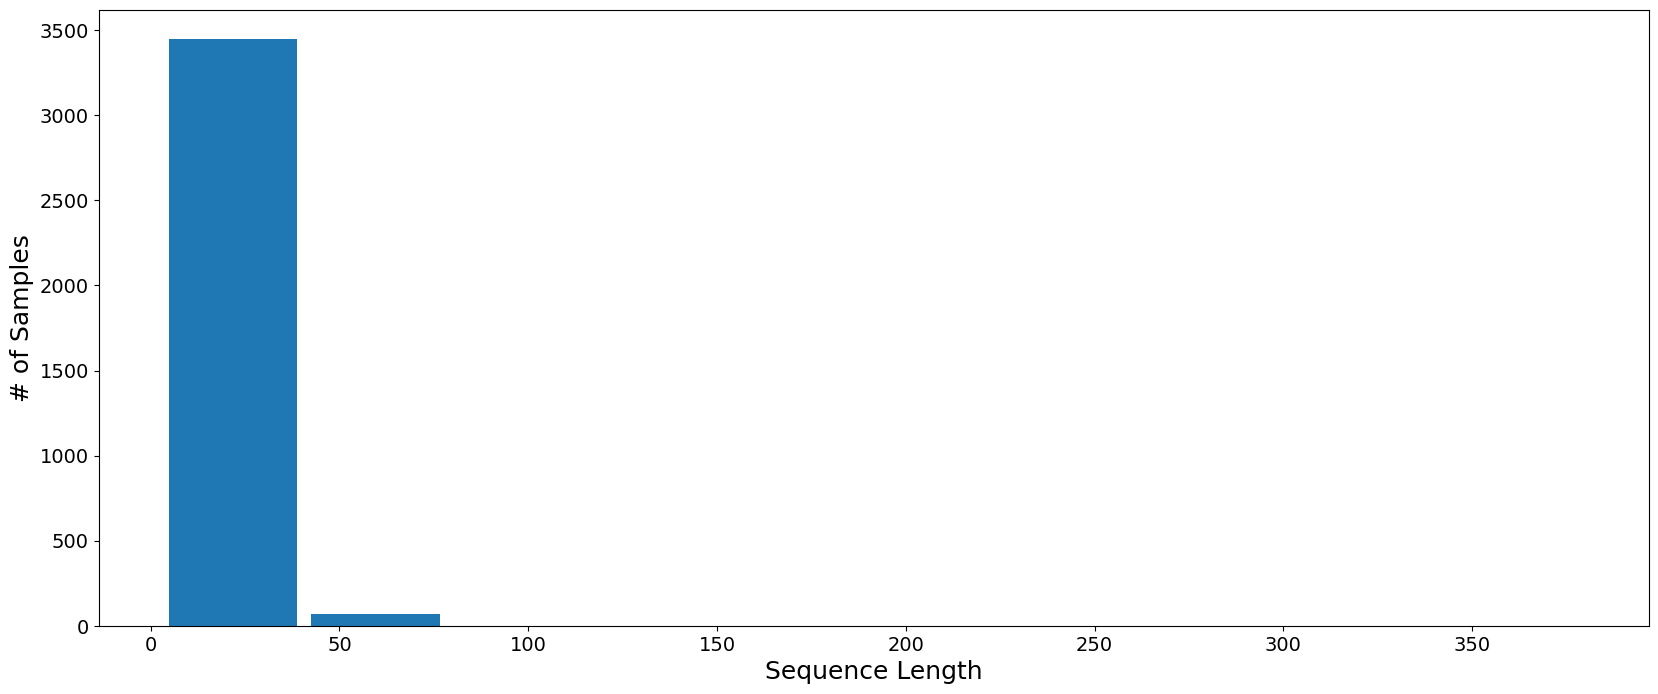

In [9]:
# install matplotlib
!pip install matplotlib
# tokenize the text feature
tokenized_feature_raw = tokenizer.batch_encode_plus(
                            # Sentences to encode
                            df.text.values.tolist(),
                            # Add '[CLS]' and '[SEP]'
                            add_special_tokens = True
                   )
# collect tokenized sentence length
token_sentence_length = [len(x) for x in tokenized_feature_raw['input_ids']]
print('max: ', max(token_sentence_length))
print('min: ', min(token_sentence_length))
# plot the distribution
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 8))
plt.hist(token_sentence_length, rwidth = 0.9)
plt.xlabel('Sequence Length', fontsize = 18)
plt.ylabel('# of Samples', fontsize = 18)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

**Identify Features and target**

In [10]:
# identify features and target
features = df.text.values.tolist()
target = df.label.values.tolist()

**Tokenize Features**

In [11]:
# tokenize features
MAX_LEN = 75
tokenized_feature = tokenizer.batch_encode_plus(
                            # Sentences to encode
                            features,
                            # Add '[CLS]' and '[SEP]'
                            add_special_tokens = True,
                            # Add empty tokens if len(text)<MAX_LEN
                            padding = 'max_length',
                            # Truncate all sentences to max length
                            truncation=True,
                            # Set the maximum length
                            max_length = MAX_LEN,
                            # Return attention mask
                            return_attention_mask = True,
                            # Return pytorch tensors
                            return_tensors = 'pt'
                   )

In [12]:
print(tokenized_feature)

{'input_ids': tensor([[     0,   3264,   2869,  ...,      1,      1,      1],
        [     0, 195823,  27018,  ...,      1,      1,      1],
        [     0, 160160,  31354,  ...,      1,      1,      1],
        ...,
        [     0, 117457,  18017,  ...,      1,      1,      1],
        [     0,  39093,   1187,  ...,      1,      1,      1],
        [     0,  20914,  33062,  ...,      1,      1,      1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}


**Train Test Split**

In [13]:
from sklearn.model_selection import train_test_split

# First, split the data into training and the rest
train_inputs, rest_inputs, train_labels, rest_labels, train_masks, rest_masks = train_test_split(tokenized_feature['input_ids'],
                                                                                                target,
                                                                                                tokenized_feature['attention_mask'],
                                                                                                random_state=2000,
                                                                                                test_size=0.2,
                                                                                                stratify=target)

# Then, split the rest into validation and testing
validation_inputs, test_inputs, validation_labels, test_labels, validation_masks, test_masks = train_test_split(rest_inputs,
                                                                                                                  rest_labels,
                                                                                                                  rest_masks,
                                                                                                                  random_state=2000,
                                                                                                                  test_size=0.5,
                                                                                                                stratify=rest_labels)
                               

In [14]:
len(validation_inputs)

352

In [15]:
train_inputs.shape

torch.Size([2815, 75])

# Create Dataloaders

In [16]:
# define batch_size
batch_size = 16
# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, torch.tensor(train_labels))
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
# Create the DataLoader for our Validation set
validation_data = TensorDataset(validation_inputs, validation_masks, torch.tensor(validation_labels))
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)
# Create the DataLoader for our test set
test_data = TensorDataset(test_inputs, test_masks, torch.tensor(test_labels))
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)


# Define XMLR Pretrained model

In [17]:

from transformers import XLMRobertaForSequenceClassification, AdamW, get_linear_schedule_with_warmup
model = XLMRobertaForSequenceClassification.from_pretrained(
    "xlm-roberta-base",
    # Specify number of classes
    num_labels = len(set(target)),
    # Whether the model returns attentions weights
    output_attentions = False,
    # Whether the model returns all hidden-states
    output_hidden_states = False
)

2024-04-29 19:19:46.799051: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-29 19:19:46.799168: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-29 19:19:46.953416: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Downloading:   0%|          | 0.00/1.04G [00:00<?, ?B/s]

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense

**Define Optimizer**

In [18]:
# Optimizer
optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8,
                  weight_decay=0.01
                )

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


**Define Scheduler and epochs**

In [19]:
# Number of training epochs
epochs = 6
# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs
# Create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 5,
                                            num_training_steps = total_steps)

In [20]:
import torch

# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('Using GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('Using CPU')


Using GPU: Tesla T4


In [21]:
#move model to device
model.to(device)

XLMRobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [22]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


In [23]:
import numpy as np
import random

seed_val = 111

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Training and Validation Phase

In [24]:
from sklearn.metrics import classification_report

train_losses= []
val_losses=[]

for n in range(epochs):
    # List to store predictions and ground truth labels for both training and validation sets
    train_preds = []
    train_labels_all = []
    val_preds = []
    val_labels_all = []

    train_loss = 0
    val_loss = 0
    start_time = time.time()
    
    # Calculate number of mini-batches for training and validation sets
    num_mb_train = len(train_dataloader)
    num_mb_val = len(validation_dataloader)

    # Training phase
    for k, (mb_x, mb_m, mb_y) in enumerate(train_dataloader):
        optimizer.zero_grad()
        model.train()

        mb_x = mb_x.to(device)
        mb_m = mb_m.to(device)
        mb_y = mb_y.to(device)

        outputs = model(mb_x, attention_mask=mb_m, labels=mb_y)
        loss = outputs[0]
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        train_loss += loss.data / num_mb_train

        # Append predictions and labels
        train_preds += torch.argmax(outputs.logits, dim=1).cpu().tolist()
        train_labels_all += mb_y.cpu().tolist()

    # Validation phase
    with torch.no_grad():
        model.eval()

        for k, (mb_x, mb_m, mb_y) in enumerate(validation_dataloader):
            mb_x = mb_x.to(device)
            mb_m = mb_m.to(device)
            mb_y = mb_y.to(device)

            outputs = model(mb_x, attention_mask=mb_m, labels=mb_y)
            loss = outputs[0]
            val_loss += loss.data / num_mb_val

            # Append predictions and labels
            val_preds += torch.argmax(outputs.logits, dim=1).cpu().tolist()
            val_labels_all += mb_y.cpu().tolist()

    # Compute metrics
    train_report = classification_report(train_labels_all, train_preds, target_names=['NOT', 'HOF'])
    val_report = classification_report(val_labels_all, val_preds, target_names=['NOT', 'HOF'])

    print(f'Training report after iteration {n+1}:\n{train_report}')
    print(f'Validation report after iteration {n+1}:\n{val_report}')

    train_losses.append(train_loss.cpu())
    val_losses.append(val_loss.cpu())

    end_time = time.time()
    epoch_mins, epoch_secs = divmod(end_time - start_time, 60)
    print(f'Time: {epoch_mins}m {epoch_secs}s')


Training report after iteration 1:
              precision    recall  f1-score   support

         NOT       0.66      0.32      0.43       921
         HOF       0.74      0.92      0.82      1894

    accuracy                           0.72      2815
   macro avg       0.70      0.62      0.63      2815
weighted avg       0.71      0.72      0.69      2815

Validation report after iteration 1:
              precision    recall  f1-score   support

         NOT       0.48      0.97      0.65       115
         HOF       0.97      0.49      0.66       237

    accuracy                           0.65       352
   macro avg       0.73      0.73      0.65       352
weighted avg       0.81      0.65      0.65       352

Time: 0.0m 51.39634704589844s
Training report after iteration 2:
              precision    recall  f1-score   support

         NOT       0.76      0.74      0.75       921
         HOF       0.88      0.89      0.88      1894

    accuracy                           0.84  

In [25]:
print(train_losses)

[tensor(0.5710), tensor(0.3971), tensor(0.2932), tensor(0.2698), tensor(0.2233), tensor(0.1984)]


In [26]:
print(val_losses)

[tensor(0.5874), tensor(0.2819), tensor(0.3128), tensor(0.2898), tensor(0.3489), tensor(0.3595)]


# Testing Phase

In [27]:
# Testing 
model.eval()
test_preds = []
test_labels_all = []

with torch.no_grad():
    for mb_x, mb_m, mb_y in test_dataloader:
        mb_x = mb_x.to(device)
        mb_m = mb_m.to(device)
        mb_y = mb_y.to(device)

        outputs = model(mb_x, attention_mask=mb_m, labels=mb_y)
        test_preds += torch.argmax(outputs.logits, dim=1).cpu().tolist()
        test_labels_all += mb_y.cpu().tolist()

# Compute and print classification report for testing
test_report = classification_report(test_labels_all, test_preds, target_names=['NOT', 'HOF'])
print(f'Testing report:\n{test_report}')

Testing report:
              precision    recall  f1-score   support

         NOT       0.80      0.90      0.84       115
         HOF       0.95      0.89      0.92       237

    accuracy                           0.89       352
   macro avg       0.87      0.89      0.88       352
weighted avg       0.90      0.89      0.89       352



In [28]:
from sklearn.metrics import f1_score
f1=f1_score(test_labels_all, test_preds)
print(f1)

0.9173913043478261


**Confusion matrix for Test Data**

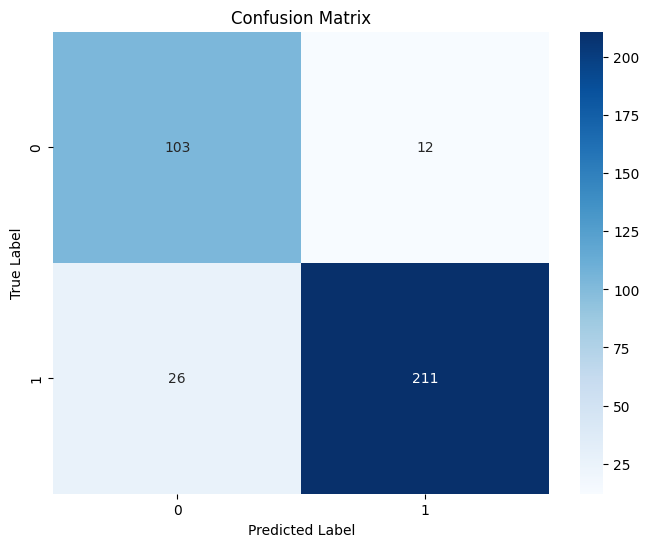

In [29]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = confusion_matrix(test_labels_all, test_preds)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Testing on provided input

In [33]:

# Define your input sentence
# sentence = "न फुगावताही चिरकतात त्याला नारायण राणे म्हणतात"
# sentence = "लवड्या अगोदरच रडायला लागलास तू"
# sentence = "अनिल परबांना रामदास कदम का म्हणाले? 'या हरामखोराला आवरा'"
sentence ="काही लोकांना सांगून उपयोग नाही त्यांच्या गुडघ्यात मेंदू आहे"
# Tokenize input sentence
encoding = tokenizer(sentence, return_tensors="pt")

# Move input tensors to the same device as the model
encoding = {k: v.to(device) for k, v in encoding.items()}

# Perform inference
with torch.no_grad():
    outputs = model(**encoding)

# Get predicted logits
logits = outputs[0]

# Get predicted class index (index with the highest probability)
predicted_class_index = logits.argmax(-1).item()

# Print predicted class index
print("Predicted class index:", predicted_class_index)

Predicted class index: 0
